In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind         
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import CategoricalNB
import itertools
from statsmodels.stats.multitest import multipletests

In [174]:
df = pd.read_csv("covid19_data.csv")  
print(df.shape)

(209, 17)


In [175]:
#remove noise 
df.columns = (df.columns.str.strip()
                          .str.lower()
                          .str.replace(' ', '_')
                          .str.replace('-', '_'))


In [176]:
#convert columns to numeric 
for c in ["Deaths/1Mpop", "TotCases/1Mpop", "Tests/1Mpop", "Population", "TotalCases"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

#remove duplicates rows
df = df.drop_duplicates()


if "Continent" in df.columns:
    df = df[df["Continent"].notna()].copy()
elif "Continent" in df.columns:  
    df = df[df["Continent"].notna()].copy()

print( df.shape)
df.head()


(209, 17)


,country/region,continent,population,totalcases,newcases,totaldeaths,newdeaths,totalrecovered,newrecovered,activecases,"serious,critical",tot_cases/1m_pop,deaths/1m_pop,totaltests,tests/1m_pop,who_region,iso_alpha
0,USA,North America,3.311981e+08,5032179,NaN,162804.0,NaN,2576668.0,NaN,2292707.0,18296.0,15194.0,492.0,63139605.0,190640.0,Americas,USA
1,Brazil,South America,2.127107e+08,2917562,NaN,98644.0,NaN,2047660.0,NaN,771258.0,8318.0,13716.0,464.0,13206188.0,62085.0,Americas,BRA
2,India,Asia,1.381345e+09,2025409,NaN,41638.0,NaN,1377384.0,NaN,606387.0,8944.0,1466.0,30.0,22149351.0,16035.0,South-EastAsia,IND
3,Russia,Europe,1.459409e+08,871894,NaN,14606.0,NaN,676357.0,NaN,180931.0,2300.0,5974.0,100.0,29716907.0,203623.0,Europe,RUS
4,South Africa,Africa,5.938157e+07,538184,NaN,9604.0,NaN,387316.0,NaN,141264.0,539.0,9063.0,162.0,3149807.0,53044.0,Africa,ZAF


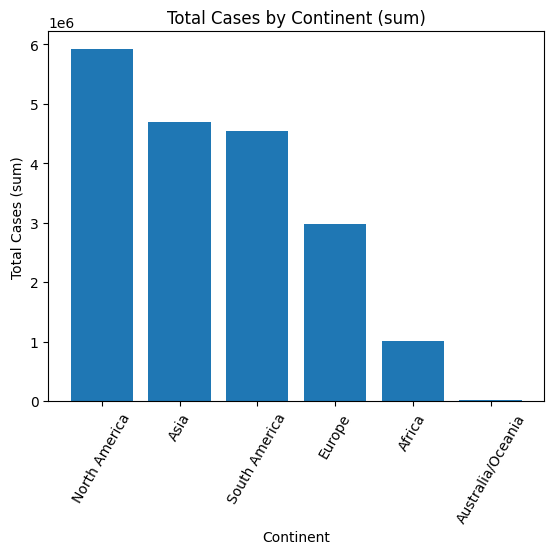

In [177]:
#cases by continent graph

by_cont = (
    df.dropna(subset=['continent']).groupby('continent')['totalcases'].sum().sort_values(ascending=False)
)
plt.bar(by_cont.index, by_cont.values)
plt.title('Total Cases by Continent (sum)')
plt.xlabel('Continent')
plt.ylabel('Total Cases (sum)')
plt.xticks(rotation=60)
plt.show()


In [178]:
descriptive = df.describe()
print(descriptive)

         population    totalcases     newcases    totaldeaths   newdeaths  \
count  2.080000e+02  2.090000e+02     4.000000     188.000000    3.000000   
mean   3.041549e+07  9.171850e+04  1980.500000    3792.590426  300.000000   
std    1.047661e+08  4.325867e+05  3129.611424   15487.184877  451.199512   
min    8.010000e+02  1.000000e+01    20.000000       1.000000    1.000000   
25%    9.663140e+05  7.120000e+02    27.500000      22.000000   40.500000   
50%    7.041972e+06  4.491000e+03   656.000000     113.000000   80.000000   
75%    2.575614e+07  3.689600e+04  2609.000000     786.000000  449.500000   
max    1.381345e+09  5.032179e+06  6590.000000  162804.000000  819.000000   

       totalrecovered  newrecovered   activecases  serious,critical  \
count    2.050000e+02      3.000000  2.050000e+02        122.000000   
mean     5.887898e+04   1706.000000  2.766433e+04        534.393443   
std      2.566984e+05   2154.779803  1.746327e+05       2047.518613   
min      7.000000e+00 

In [179]:
types = (
    df.dtypes #int, float, object type
    .astype(str) 
    .rename("dtype")#name the column
    .reset_index().rename(columns={"index":"variable"})) #name the column of columns 
types["class"] = np.where(types["dtype"].str.contains("object|category"),"categorical", "numeric")
display(types.head(40))


,variable,dtype,class
0,country/region,object,categorical
1,continent,object,categorical
2,population,float64,numeric
3,totalcases,int64,numeric
4,newcases,float64,numeric
5,totaldeaths,float64,numeric
6,newdeaths,float64,numeric
7,totalrecovered,float64,numeric
8,newrecovered,float64,numeric
9,activecases,float64,numeric


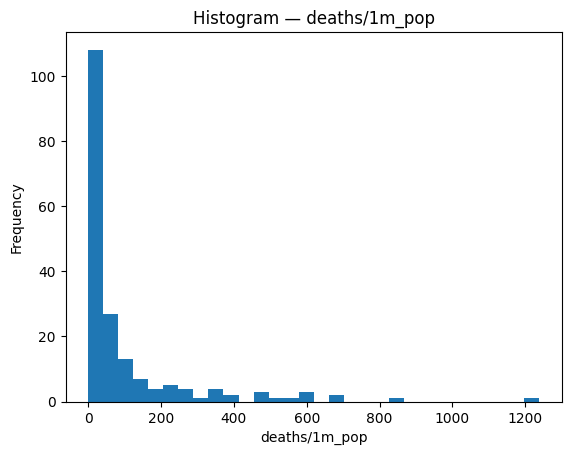

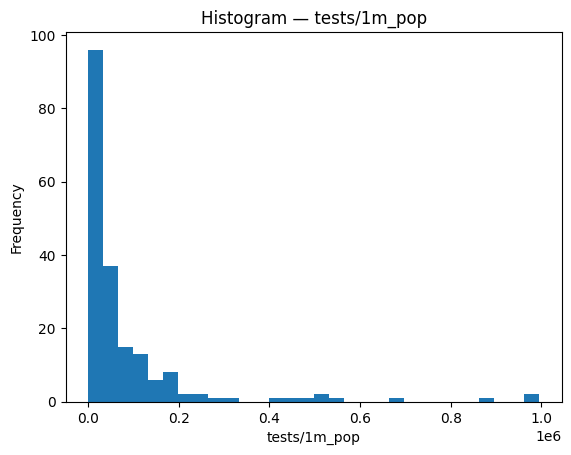

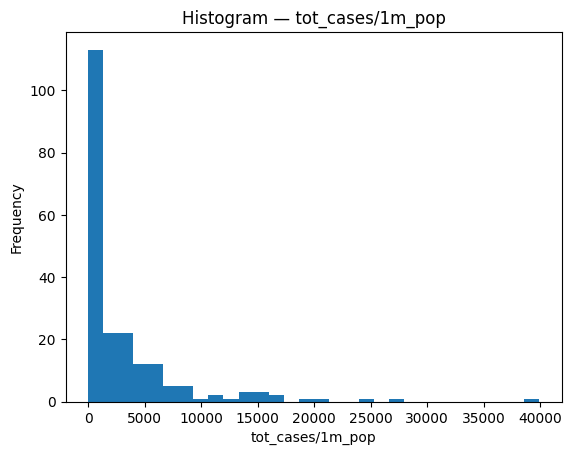

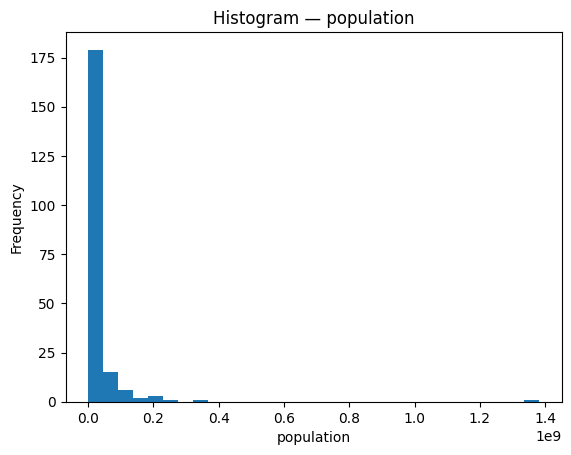

In [180]:
for c in ["deaths/1m_pop", "tests/1m_pop", "tot_cases/1m_pop", "population"]:
    if c in df.columns:
        s = df[c].dropna()
        if s.empty: 
            continue
        plt.figure()
        plt.hist(s, bins=30)
        plt.title(f"Histogram — {c}")
        plt.xlabel(c)
        plt.ylabel("Frequency")
        plt.show()


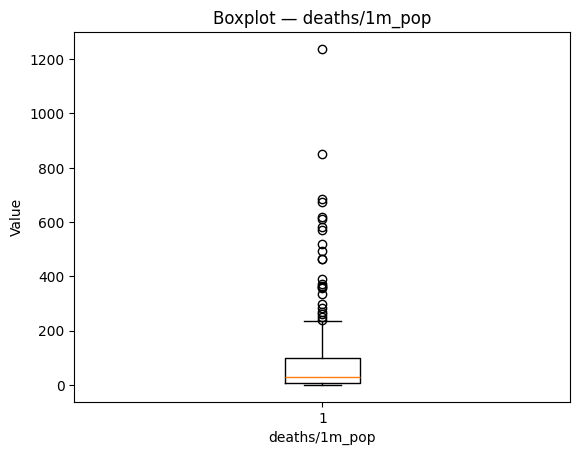

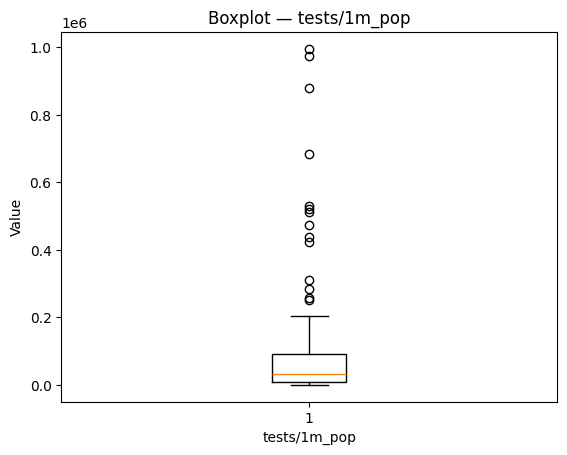

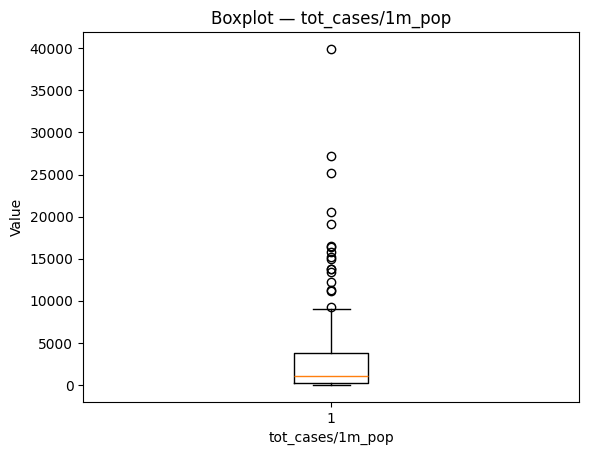

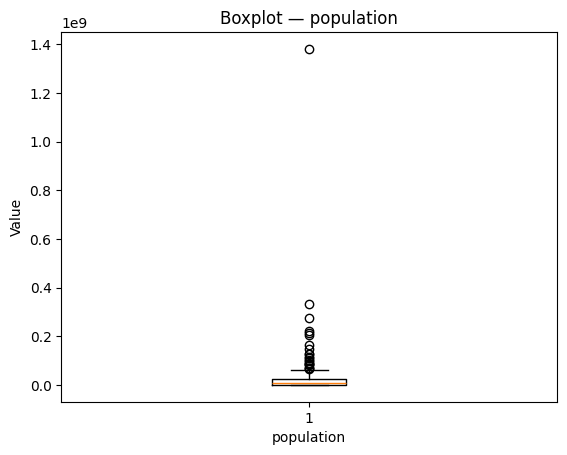

In [181]:
for c in ["deaths/1m_pop", "tests/1m_pop", "tot_cases/1m_pop", "population"]:
    if c in df.columns:
        s = df[c].dropna()
        if s.empty: 
            continue
        plt.figure()
        plt.boxplot(s)
        plt.title(f"Boxplot — {c}")
        plt.xlabel(c)
        plt.ylabel("Value")
        plt.show()


In [182]:
df.drop(columns=["newcases","newdeaths","newrecovered"], inplace=True)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country/region    209 non-null    object 
 1   continent         208 non-null    object 
 2   population        208 non-null    float64
 3   totalcases        209 non-null    int64  
 4   totaldeaths       188 non-null    float64
 5   totalrecovered    205 non-null    float64
 6   activecases       205 non-null    float64
 7   serious,critical  122 non-null    float64
 8   tot_cases/1m_pop  208 non-null    float64
 9   deaths/1m_pop     187 non-null    float64
 10  totaltests        191 non-null    float64
 11  tests/1m_pop      191 non-null    float64
 12  who_region        184 non-null    object 
 13  iso_alpha         209 non-null    object 
dtypes: float64(9), int64(1), object(4)
memory usage: 23.0+ KB


In [ ]:
clean = df.copy()
num = clean.select_dtypes(include='number')

q1  = num.quantile(.25)
q3  = num.quantile(.75)
iqr = q3 - q1
lo  = q1 - 1.5*iqr
hi  = q3 + 1.5*iqr

print(f"Before outlier handling: {clean.isna().sum()}")
upper_bounds = {ش
    "population": 0.3*1e9,
    "tot_cases/1m_pop": 25000
}
for column in num.columns:
    if column in upper_bounds:
        hi[column] = upper_bounds[column]
        clean[column].clip(lo[column], hi[column])
print(f"After outlier handling: {clean.isna().sum()}")

Before outlier handling: country/region       0
continent            1
population           1
totalcases           0
totaldeaths         21
totalrecovered       4
activecases          4
serious,critical    87
tot_cases/1m_pop     1
deaths/1m_pop       22
totaltests          18
tests/1m_pop        18
who_region          25
iso_alpha            0
dtype: int64
After outlier handling: country/region       0
continent            1
population           1
totalcases           0
totaldeaths         21
totalrecovered       4
activecases          4
serious,critical    87
tot_cases/1m_pop     1
deaths/1m_pop       22
totaltests          18
tests/1m_pop        18
who_region          25
iso_alpha            0
dtype: int64


In [185]:
column="activecases"
print("all",clean[column].where((clean[column] <= hi[column]) & clean[column].notna()))

all 0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
204    2.0
205    6.0
206    0.0
207    0.0
208    1.0
Name: activecases, Length: 209, dtype: float64


In [186]:
num.columns[0]

'population'

In [187]:
hi

population          3.000000e+08
totalcases          9.117200e+04
totaldeaths         1.932000e+03
totalrecovered      5.088150e+04
activecases         1.768100e+04
serious,critical    3.957500e+02
tot_cases/1m_pop    2.500000e+04
deaths/1m_pop       2.360000e+02
totaltests          1.855612e+06
tests/1m_pop        2.169515e+05
dtype: float64

In [188]:
clean[num.columns].max()

population          1.381345e+09
totalcases          5.032179e+06
totaldeaths         1.628040e+05
totalrecovered      2.576668e+06
activecases         2.292707e+06
serious,critical    1.829600e+04
tot_cases/1m_pop    3.992200e+04
deaths/1m_pop       1.238000e+03
totaltests          6.313960e+07
tests/1m_pop        9.952820e+05
dtype: float64

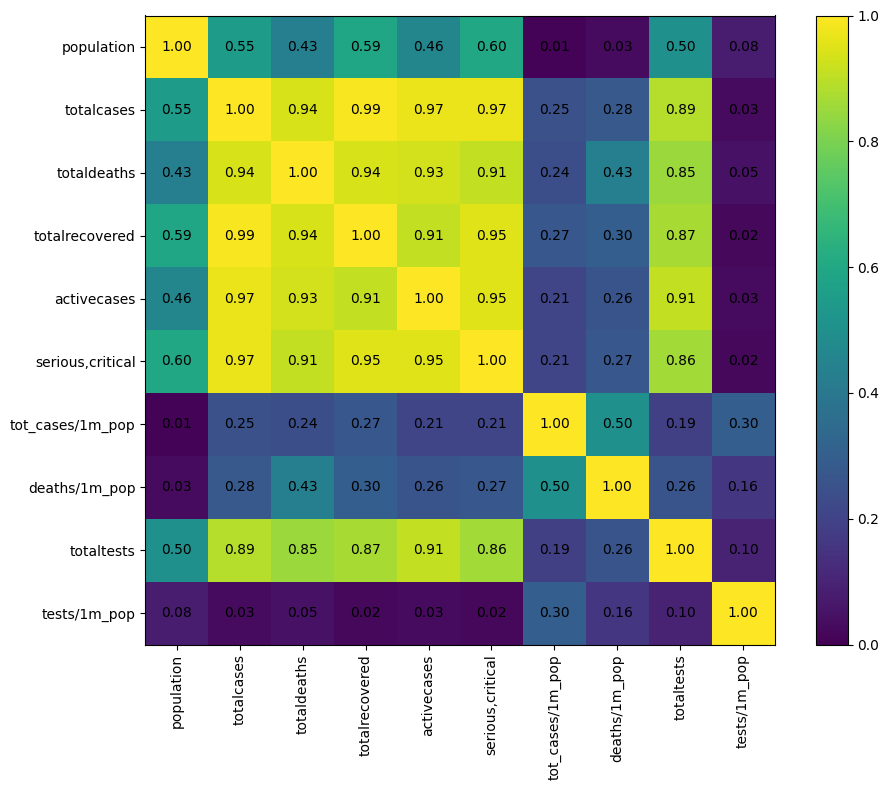

In [189]:
corr = clean.select_dtypes(include='number').corr().abs().round(2) #numerical columns only 


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr,vmin=0, vmax=1)  
plt.colorbar(im, ax=ax)


ax.set_xticks(np.arange(corr.shape[1]))
ax.set_yticks(np.arange(corr.shape[0]))
ax.set_xticklabels(corr.columns, rotation=90) #range 0,1 
ax.set_yticklabels(corr.columns)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iat[i, j]:.2f}", ha='center', va='center')

plt.tight_layout()
plt.show()


ANOVA

In [190]:
col_y = 'deaths/1m_pop'  
col_g = 'continent'      

sub = clean[[col_g, col_y]].copy() 
sub[col_y] = pd.to_numeric(sub[col_y], errors='coerce') # the death column numeric 
sub = sub.dropna()

counts = sub.groupby(col_g)[col_y].size() #each continent conatin NO.of countries 
ok = counts[counts >= 2].index 
sub = sub[sub[col_g].isin(ok)]

#make list about each continent to test
samples = [vals.to_numpy(dtype=float) for _, vals in sub.groupby(col_g)[col_y]]

print("sample dtypes:", [s.dtype for s in samples])

#W, p_lev = levene(*samples, center='median')
F, p = f_oneway(*samples)
#print(f"Levene: W={W:.3f}, p={p_lev:.4f}")
print(f"ANOVA : F={F:.3f}, p={p:.3e}")


sample dtypes: [dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]
ANOVA : F=10.832, p=3.972e-09


In [191]:
#post-hoc
#trying to know whoes diff than who 
groups = {g: v[col_y].to_numpy(float) for g, v in sub.groupby(col_g)}

pairs, tvals, pvals, meanA, meanB, diffs = [], [], [], [], [], []
for a, b in itertools.combinations(groups.keys(), 2):
    x, y = groups[a], groups[b]
    t, p = ttest_ind(x, y, equal_var=False)    
    pairs.append(f"{a} vs {b}"); tvals.append(t); pvals.append(p)
    meanA.append(x.mean()); meanB.append(y.mean()); diffs.append(y.mean()-x.mean())


rej, p_adj, _, _ = multipletests(pvals, alpha=0.05, method='holm')

posthoc = pd.DataFrame({
    "pair": pairs,
    "mean_A": meanA,
    "mean_B": meanB,
    "diff(B-A)": diffs,
    "t": tvals,
    "p_raw": pvals,
    "p_adj_holm": p_adj,
    "significant(0.05)": rej
}).sort_values("p_adj_holm")

print("Significant pairs (Holm 0.05):")
display(posthoc[posthoc["significant(0.05)"]])
print("\nAll pairs:")
display(posthoc)


Significant pairs (Holm 0.05):


,pair,mean_A,mean_B,diff(B-A),t,p_raw,p_adj_holm,significant(0.05)
9,Australia/Oceania vs Europe,3.825000,214.955556,211.130556,-5.317605,0.000003,0.000050,True
2,Africa vs Europe,18.241455,214.955556,196.714101,-4.934636,0.000011,0.000160,True
6,Asia vs Europe,43.971429,214.955556,170.984127,-4.190646,0.000115,0.001498,True
5,Asia vs Australia/Oceania,43.971429,3.825000,-40.146429,4.053313,0.000204,0.002446,True
10,Australia/Oceania vs North America,3.825000,110.607143,106.782143,-4.085990,0.000345,0.003795,True
3,Africa vs North America,18.241455,110.607143,92.365688,-3.501884,0.001547,0.015469,True
11,Australia/Oceania vs South America,3.825000,216.769231,212.944231,-3.599963,0.003631,0.032677,True
1,Africa vs Australia/Oceania,18.241455,3.825000,-14.416455,3.040407,0.004326,0.034606,True
4,Africa vs South America,18.241455,216.769231,198.527776,-3.350158,0.005704,0.039929,True



All pairs:


,pair,mean_A,mean_B,diff(B-A),t,p_raw,p_adj_holm,significant(0.05)
9,Australia/Oceania vs Europe,3.825000,214.955556,211.130556,-5.317605,0.000003,0.000050,True
2,Africa vs Europe,18.241455,214.955556,196.714101,-4.934636,0.000011,0.000160,True
6,Asia vs Europe,43.971429,214.955556,170.984127,-4.190646,0.000115,0.001498,True
5,Asia vs Australia/Oceania,43.971429,3.825000,-40.146429,4.053313,0.000204,0.002446,True
10,Australia/Oceania vs North America,3.825000,110.607143,106.782143,-4.085990,0.000345,0.003795,True
3,Africa vs North America,18.241455,110.607143,92.365688,-3.501884,0.001547,0.015469,True
11,Australia/Oceania vs South America,3.825000,216.769231,212.944231,-3.599963,0.003631,0.032677,True
1,Africa vs Australia/Oceania,18.241455,3.825000,-14.416455,3.040407,0.004326,0.034606,True
4,Africa vs South America,18.241455,216.769231,198.527776,-3.350158,0.005704,0.039929,True
8,Asia vs South America,43.971429,216.769231,172.797802,-2.885067,0.013079,0.078472,False


In [192]:
target_name = "deaths/1m_pop"

df_train=clean[clean[target_name].notna()]
df_train.reset_index(inplace=True)
df_test=clean[clean[target_name].isna()]
df_test.reset_index(inplace=True)    



In [193]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             187 non-null    int64  
 1   country/region    187 non-null    object 
 2   continent         187 non-null    object 
 3   population        187 non-null    float64
 4   totalcases        187 non-null    int64  
 5   totaldeaths       187 non-null    float64
 6   totalrecovered    183 non-null    float64
 7   activecases       183 non-null    float64
 8   serious,critical  118 non-null    float64
 9   tot_cases/1m_pop  187 non-null    float64
 10  deaths/1m_pop     187 non-null    float64
 11  totaltests        173 non-null    float64
 12  tests/1m_pop      173 non-null    float64
 13  who_region        171 non-null    object 
 14  iso_alpha         187 non-null    object 
dtypes: float64(9), int64(2), object(4)
memory usage: 22.0+ KB


In [194]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             22 non-null     int64  
 1   country/region    22 non-null     object 
 2   continent         21 non-null     object 
 3   population        21 non-null     float64
 4   totalcases        22 non-null     int64  
 5   totaldeaths       1 non-null      float64
 6   totalrecovered    22 non-null     float64
 7   activecases       22 non-null     float64
 8   serious,critical  4 non-null      float64
 9   tot_cases/1m_pop  21 non-null     float64
 10  deaths/1m_pop     0 non-null      float64
 11  totaltests        18 non-null     float64
 12  tests/1m_pop      18 non-null     float64
 13  who_region        13 non-null     object 
 14  iso_alpha         22 non-null     object 
dtypes: float64(9), int64(2), object(4)
memory usage: 2.7+ KB


In [195]:
data_train = df_train[["tests/1m_pop","tot_cases/1m_pop","deaths/1m_pop","population","continent"]]
data_test = df_test[["tests/1m_pop","tot_cases/1m_pop","deaths/1m_pop","population","continent"]]

In [196]:
#any non numeric data turns to NaN 
# for c in [pop_col, tests_col, cases_col, death_col]:
#     clean[c] = pd.to_numeric(clean[c], errors="coerce")

#IQR (high, mid, low)
def change_to_cat(x, q1, q3):
    if pd.isna(x) or pd.isna(q1) or pd.isna(q3):
        return np.nan
    if x < q1:  return "low"
    if x > q3:  return "high"
    return "mid"

data_train = data_train.apply(lambda col: pd.Categorical(col.apply(lambda x: change_to_cat(x, *col.quantile([.25, .75])))) if col.name != "continent" else pd.Categorical(col), axis=0)
data_test = data_test.apply(lambda col: pd.Categorical(col.apply(lambda x: change_to_cat(x, *col.quantile([.25, .75])))) if col.name != "continent" else pd.Categorical(col), axis=0)

In [197]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   tests/1m_pop      173 non-null    category
 1   tot_cases/1m_pop  187 non-null    category
 2   deaths/1m_pop     187 non-null    category
 3   population        187 non-null    category
 4   continent         187 non-null    category
dtypes: category(5)
memory usage: 1.8 KB


naive bayes

In [199]:

X_cols = ["population","tests/1m_pop","tot_cases/1m_pop","continent"]
y_col  = "deaths/1m_pop"

# اختياري: شيل أي صف فيه قيم ناقصة في الأعمدة اللي هنستخدمها
df = df.dropna(subset=X_cols + [y_col]).reset_index(drop=True)

# 3) Split لمرة واحدة (بدون labeled/unlabeled، وبدون CV)
# هنستخدم qcut على y علشان نعمل stratify متوازن بعد ما نحوّل y لفئات لاحقًا
y_strata = pd.qcut(df[y_col], 3, labels=False, duplicates="drop")

train_idx, val_idx = train_test_split(
    df.index, test_size=0.25, random_state=42, stratify=y_strata
)
train = df.loc[train_idx].copy()
val   = df.loc[val_idx].copy()

# 4) Binning: حوّل الأرقام إلى low/mid/high باستخدام TRAIN فقط
num_cols = ["population","tests/1m_pop","tot_cases/1m_pop", y_col]

# احسب Q1,Q3 من train فقط
quantiles = {col: train[col].quantile([0.25, 0.75]).values for col in num_cols}

def bin_by_q13(s, q1, q3):
    return pd.cut(s, [-float("inf"), q1, q3, float("inf")],
                  labels=["low","mid","high"], include_lowest=True)

for col in num_cols:
    q1, q3 = quantiles[col]
    train[col] = bin_by_q13(train[col], q1, q3)
    val[col]   = bin_by_q13(val[col],   q1,  q3)

# 5) Encode (fit على TRAIN فقط)
enc_X = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
enc_y = OrdinalEncoder()

X_train = enc_X.fit_transform(train[X_cols])
X_val   = enc_X.transform(val[X_cols])

y_train = enc_y.fit_transform(train[[y_col]]).ravel()
y_val   = enc_y.transform(val[[y_col]]).ravel()

# 6) Train CategoricalNB
nb = CategoricalNB()
nb.fit(X_train, y_train)

# 7) Predict على الـ validation
y_pred = nb.predict(X_val)

# 8) Evaluate
print("Validation accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("\nClassification report:\n", classification_report(y_val, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_val, y_pred))

# 9) Preview بنتايج مفهومة (نفك ترميز y)
y_true_labels = enc_y.inverse_transform(y_val.reshape(-1,1)).ravel()
y_pred_labels = enc_y.inverse_transform(y_pred.reshape(-1,1)).ravel()

preview = val[X_cols].copy()
preview["y_true"] = y_true_labels
preview["y_pred"] = y_pred_labels
print("\nPreview:\n", preview.head(10))


Validation accuracy: 0.7045

Classification report:
               precision    recall  f1-score   support

         0.0       0.86      0.60      0.71        10
         1.0       0.54      0.78      0.64         9
         2.0       0.75      0.72      0.73        25

    accuracy                           0.70        44
   macro avg       0.72      0.70      0.69        44
weighted avg       0.73      0.70      0.71        44


Confusion matrix:
 [[ 6  0  4]
 [ 0  7  2]
 [ 1  6 18]]

Preview:
     population tests/1m_pop tot_cases/1m_pop      continent y_true y_pred
152        mid         high              low         Africa    mid    low
101        mid          low              low         Africa    mid    low
107        low          mid              mid         Africa    mid    mid
131       high          low              low         Africa    low    low
137        low         high              mid         Europe    mid    mid
30         mid          mid             high          